In [411]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [412]:
def load_dataset(path, classes):
    class_images = []
    
    for cls in classes :
        cls_imgs = []
        img_names = os.listdir(path + cls + "/")
        i=0
        for img_name in img_names :
            cls_imgs.append(cv2.resize(cv2.imread(path + cls + "/" + img_name), (300, 200)))
            if(i==100): break
            i+=1
        class_images.append(np.array(cls_imgs))
    return class_images

In [413]:
data = load_dataset("/kaggle/input/cell-images-for-detecting-malaria/cell_images/", ["Parasitized"])


In [414]:
def change_contrast(image,alpha = 1.5,beta=25):
    # Contrast control (1.0-3.0)
    # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

In [415]:
def image_cleanup(image):
    blurred = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
    thresh = cv2.threshold(blurred, 175, 250, cv2.THRESH_BINARY)[1]
    return thresh

In [416]:
def remove_noisy_regions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    mask = cv2.erode(gray, element, iterations = 50)
    mask = cv2.dilate(mask, element, iterations = 50)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    mask = cv2.erode(gray, element, iterations = 1)
    mask = cv2.dilate(mask, element, iterations = 1)
    mask = cv2.erode(mask, element)
    gray = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    return gray

In [417]:
def find_contours_and_centers(img_input):
    contours_raw, hierarchy = cv2.findContours(img_input, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [i for i in contours_raw]
    contour_centers = []
    
    for idx, c in enumerate(contours):
        M = cv2.moments(c)
        try:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        except:
            cX = int(M["m10"] / (M["m00"] + 0.0001))
            cY = int(M["m01"] / (M["m00"] + 0.0001))
        samp_bounds = cv2.boundingRect(c)
        contour_centers.append(((cX,cY), samp_bounds))
    contour_centers = sorted(contour_centers, key=lambda x: x[0])

    return (contours, contour_centers)

In [418]:
def find_contour_and_area(img_input):
    lll=img_input
    i1 = change_contrast(lll,1.5,10)
    i2 = image_cleanup(i1)
    img = remove_noisy_regions(i2)
    h,s,v = cv2.split(img)
    ab = cv2.subtract(h,s)
    fig,asx = plt.subplots(1,3)
    asx[0].imshow(h,cmap="gray")
    asx[1].imshow(s,cmap="gray")
    asx[2].imshow(ab,cmap="gray")
    fig.tight_layout()
    #plt.savefig("processing.png",dpi=300)
    conts, cents = find_contours_and_centers(s)
    # circles = [i for i in conts if np.logical_and((cv2.contourArea(i) > 650),(cv2.contourArea(i) < 4000))]
    print(len(cents))
    img = lll.copy()
    cv2.drawContours(img, conts, -1, (0,255,0), 2)
    # show_image(img)


    fig,asx = plt.subplots(1,2)
    asx[0].imshow(lll)
    asx[1].imshow(img,cmap="gray")
    fig.tight_layout()
    #plt.savefig("contour_infected.png",dpi=300)
    if(len(cents)<2):
        ratio=0
    if(len(cents)==2):
        ratio=cv2.contourArea(conts[1])/cv2.contourArea(conts[0])*100
    elif (len(cents)>2):
        area=0
        for i in range(len(cents)):
            if (i==0):continue
            area+=cv2.contourArea(conts[i])
        ratio=area/cv2.contourArea(conts[0])*100
    
    return ratio

3


1.7710270065862035

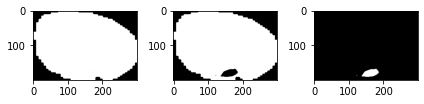

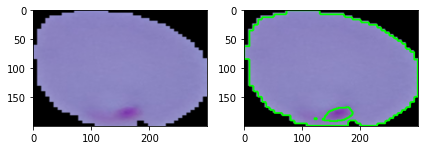

In [422]:
find_contour_and_area(data[0][5])